In [1]:
#importing all the necessary libraries.
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#importing the initial data from the file "Mallards_initial data.xlsx"
mallards=pd.read_excel("Mallards_initial data.xlsx")
#The line bellow is used for debugging.
mallards = mallards.loc[:, ~mallards.columns.str.contains('^Unnamed')]
print(mallards.tail(5))

       population  farmed       date       hour  slatitude  slongitude
19910         111       0 2012-10-03   18:46:46  56.440178   13.992034
19911         111       0 2012-10-03   19:46:42  56.439957   13.992407
19912         111       0 2012-10-03   20:47:04  56.440022   13.992071
19913         111       0 2012-10-03   21:49:33  56.440029   13.992332
19914         111       0 2012-10-03   22:48:59  56.440067   13.993050


In [3]:
# instead of any other type of grouping we choose to group the mallards by ordering them by population.
ordered = mallards.sort_values(by=["population"]).reset_index(drop=True)

In [4]:
ordered.tail(10)

,population,farmed,date,hour,slatitude,slongitude
19905,153,1,2012-10-19,04:39:28,56.500893,13.970902
19906,153,1,2012-10-19,05:39:21,56.500786,13.970841
19907,153,1,2012-10-19,06:38:23,56.500889,13.971055
19908,153,1,2012-10-19,07:38:58,56.487541,13.965097
19909,153,1,2012-10-19,08:39:03,56.487274,13.965044
19910,153,1,2012-10-19,09:39:15,56.487392,13.965101
19911,153,1,2012-10-19,10:38:33,56.487503,13.965265
19912,153,1,2012-10-19,11:38:27,56.487041,13.965001
19913,153,1,2012-10-18,07:41:34,56.487537,13.965165
19914,153,1,2012-10-08,07:59:45,56.432728,13.989956


In [5]:
#Saving the ordered by population data into the Excel file "mallards_ordered.xlsx"
ordered.to_excel("mallards_ordered.xlsx", index=False)

In [6]:
#Creating the dataframe that is going to be used as y. Each column will be used as y in a different model.
labelled = pd.DataFrame(columns=["dlatitude", "dlongitude"])

#Generating the labels by making the next coordinates as the destination coordinates for the previous row.
for i, row in ordered.iterrows():
    if i == ordered.index[-1]:
        break
    if row["population"] != ordered.iloc[i+1]["population"]:
        label_row = pd.DataFrame({"dlatitude": row["slatitude"], "dlongitude": row["slongitude"]}, index=[i])
    else:
        label_row = pd.DataFrame({"dlatitude": ordered.iloc[i+1]["slatitude"], "dlongitude": ordered.iloc[i+1]["slongitude"]}, index=[i])
    labelled = pd.concat([labelled, label_row])


In [7]:
labelled.head(10)

,dlatitude,dlongitude
0,56.439716,13.991791
1,56.440170,13.992670
2,56.440136,13.992191
3,56.441143,13.988527
4,56.439919,13.991972
5,56.439869,13.992161
6,56.439716,13.992242
7,56.439934,13.991963
8,56.439888,13.992043
9,56.440109,13.991787


In [8]:
# drop last two rows from ordered dataframe. It is used for data management.
ordered = ordered.iloc[:-2].reset_index(drop=True)

# drop last row from labelled dataframe. It is used for data management.
labelled = labelled.iloc[:-1].reset_index(drop=True)

In [9]:
print(ordered.iloc[:-1].shape)

(19912, 6)


In [10]:
print(labelled["dlatitude"].iloc[:-1].shape)

(19912,)


In [11]:
# Making different splits for different models, one for longitude and one latitude.
X_train, X_test, y_lat_train, y_lat_test = train_test_split(
    ordered.iloc[:-1], labelled["dlatitude"].iloc[:-1], test_size=0.2, random_state=42
)
X_train, X_test, y_long_train, y_long_test = train_test_split(
    ordered.iloc[:-1], labelled["dlongitude"].iloc[:-1], test_size=0.2, random_state=42
)

In [12]:
X_train.shape

(15929, 6)

In [13]:
# We use standard scaler to do our scalling, instead of manual scaling.
scaler = StandardScaler()

In [14]:
# Making sure that date and hour have the necessary format.
X_train_no_date = X_train.drop(['date', 'hour'], axis=1)
X_train_scaled = scaler.fit_transform(X_train_no_date)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_no_date.columns, index=X_train_no_date.index)
X_train_scaled_df[['date', 'hour']] = X_train[['date', 'hour']]

In [15]:
# Making sure that date and hour have the necessary format.
X_test_no_date = X_test.drop(['date', 'hour'], axis=1)
X_test_scaled = scaler.transform(X_test_no_date)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_no_date.columns, index=X_test_no_date.index)
X_test_scaled_df[['date', 'hour']] = X_test[['date', 'hour']]

In [16]:
# extract day of the week and hour of the day from datetime columns
X_train_scaled_df['weekday'] = X_train_scaled_df['date'].dt.weekday
X_train_scaled_df['hour'] = pd.to_datetime(X_train_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_train_scaled_df['hour'] = X_train_scaled_df['hour'].dt.hour

X_test_scaled_df['weekday'] = X_test_scaled_df['date'].dt.weekday
X_test_scaled_df['hour'] = pd.to_datetime(X_test_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_test_scaled_df['hour'] = X_test_scaled_df['hour'].dt.hour

# drop the original datetime columns
X_train_scaled_df = X_train_scaled_df.drop(['date'], axis=1)
X_test_scaled_df = X_test_scaled_df.drop(['date'], axis=1)

In [17]:
X_train_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
11284,0.030042,-0.524242,0.125260,0.133639,21,5
11964,0.138355,-0.524242,0.127363,0.126657,19,0
5390,-0.879784,-0.524242,0.125449,0.134608,15,4
860,-1.356359,-0.524242,0.124414,0.135708,18,2
15795,0.939869,-0.524242,0.125983,0.133088,3,0


In [18]:
X_test_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
16564,1.113169,1.907515,0.123946,0.131636,21,4
19327,1.849695,1.907515,-4.781471,-1.732344,10,0
15022,0.874881,-0.524242,0.126517,0.128668,0,3
2457,-1.139734,-0.524242,0.124135,0.135700,5,1
9210,-0.229908,-0.524242,0.121909,0.135181,17,5


In [19]:
#Important part of the code. it is the place where we set our configuration.
n_units = 32
activation = 'relu'
loss_function = 'mean_squared_error'

In [20]:
# A separate model to detect latitude.
modelLat = Sequential()
modelLat.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLat.add(Dense(1))
modelLat.compile(optimizer='adam', loss=loss_function)

In [21]:
# A separate model to detect longitude.
modelLong = Sequential()
modelLong.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLong.add(Dense(1))
modelLong.compile(optimizer='adam', loss=loss_function)

In [22]:
print(X_train_scaled_df.values.shape)

(15929, 6)


In [23]:
print(y_lat_train.values.shape)

(15929,)


In [24]:
print(modelLat.input_shape)

(None, 6)


In [25]:
X_train_scaled_df.shape

(15929, 6)

In [26]:
X_test_scaled_df.shape

(3983, 6)

In [27]:
# Fitting the data in the model for latitude.
historyLat=modelLat.fit(X_train_scaled_df.values, y_lat_train, validation_data=(X_test_scaled_df.values, y_lat_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 1s 3ms/step - loss: 1287.0203 - val_loss: 441.8122
Epoch 2/1000
498/498 [==============================] - 1s 2ms/step - loss: 364.2031 - val_loss: 291.1504
Epoch 3/1000
498/498 [==============================] - 0s 790us/step - loss: 237.3801 - val_loss: 172.0264
Epoch 4/1000
498/498 [==============================] - 2s 4ms/step - loss: 118.9117 - val_loss: 67.9310
Epoch 5/1000
498/498 [==============================] - 2s 4ms/step - loss: 38.4818 - val_loss: 17.8660
Epoch 6/1000
498/498 [==============================] - 2s 4ms/step - loss: 10.4324 - val_loss: 5.6457
Epoch 7/1000
498/498 [==============================] - 2s 3ms/step - loss: 3.5453 - val_loss: 2.0208
Epoch 8/1000
498/498 [==============================] - 1s 3ms/step - loss: 1.3595 - val_loss: 0.9579
Epoch 9/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.7028 - val_loss: 0.5904
Epoch 10/1000
498/498 [==============================] - 1s 3

498/498 [==============================] - 1s 1ms/step - loss: 0.0037 - val_loss: 0.1254
Epoch 81/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0034 - val_loss: 0.1253
Epoch 82/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.1270
Epoch 83/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.1260
Epoch 84/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.1227
Epoch 85/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.1222
Epoch 86/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.1231
Epoch 87/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.1206
Epoch 88/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.1209
Epoch 89/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - v

498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0910
Epoch 160/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0890
Epoch 161/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0885
Epoch 162/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0876
Epoch 163/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0866
Epoch 164/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0863
Epoch 165/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0886
Epoch 166/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0874
Epoch 167/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0884
Epoch 168/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

Epoch 238/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0680
Epoch 239/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0671
Epoch 240/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0679
Epoch 241/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0675
Epoch 242/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0669
Epoch 243/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0654
Epoch 244/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0668
Epoch 245/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0663
Epoch 246/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0657
Epoch 247/1000
498/498 [==============================] - 1s 2ms

498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0538
Epoch 317/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0542
Epoch 318/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0549
Epoch 319/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0527
Epoch 320/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0534
Epoch 321/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0524
Epoch 322/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0519
Epoch 323/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0521
Epoch 324/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0538
Epoch 325/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0451 - ETA: 0s - loss: 0.0
Epoch 395/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0438
Epoch 396/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0439
Epoch 397/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0417
Epoch 398/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0415
Epoch 399/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0420: 0s - loss: 0.0
Epoch 400/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0477
Epoch 401/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0422
Epoch 402/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0417
Epoch 403/1000
498/498 [=================

498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0353
Epoch 473/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0338
Epoch 474/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0342
Epoch 475/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0356
Epoch 476/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0330
Epoch 477/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0350
Epoch 478/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0339
Epoch 479/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0333
Epoch 480/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0332
Epoch 481/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0268
Epoch 551/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0271
Epoch 552/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0280
Epoch 553/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0275
Epoch 554/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0268
Epoch 555/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0302
Epoch 556/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0278
Epoch 557/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0293
Epoch 558/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0265
Epoch 559/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 0.0228
Epoch 629/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0241
Epoch 630/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0227
Epoch 631/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0250
Epoch 632/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0236
Epoch 633/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0235
Epoch 634/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0257
Epoch 635/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0232
Epoch 636/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0021 - val_loss: 0.0238
Epoch 637/1000
498/498 [==============================] - 1s 1ms/step - loss: 0

498/498 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0269
Epoch 707/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0261
Epoch 708/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0221
Epoch 709/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0219
Epoch 710/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0223
Epoch 711/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0222
Epoch 712/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0218
Epoch 713/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0221
Epoch 714/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0215
Epoch 715/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0179
Epoch 785/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0173
Epoch 786/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0185
Epoch 787/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0171
Epoch 788/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0177
Epoch 789/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0177
Epoch 790/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0179
Epoch 791/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0016 - val_loss: 0.0184
Epoch 792/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0199
Epoch 793/1000
498/498 [==============================] - 1s 1ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0148
Epoch 863/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0152
Epoch 864/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0019 - val_loss: 0.0141
Epoch 865/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0143
Epoch 866/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0156
Epoch 867/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0140
Epoch 868/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0152
Epoch 869/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0144
Epoch 870/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 871/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0018 - val_loss: 0.0125
Epoch 941/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0027 - val_loss: 0.0131
Epoch 942/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0018 - val_loss: 0.0128
Epoch 943/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0120
Epoch 944/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 0.0122
Epoch 945/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 0.0146
Epoch 946/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0121
Epoch 947/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0128
Epoch 948/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0122
Epoch 949/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

In [28]:
# Fitting the data in the model for latitude.
historyLong=modelLong.fit(X_train_scaled_df.values, y_long_train, validation_data=(X_test_scaled_df.values, y_long_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 1s 2ms/step - loss: 42.2964 - val_loss: 11.9511
Epoch 2/1000
498/498 [==============================] - 1s 2ms/step - loss: 6.5206 - val_loss: 2.6011
Epoch 3/1000
498/498 [==============================] - 1s 2ms/step - loss: 1.2357 - val_loss: 0.4956
Epoch 4/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.2850 - val_loss: 0.1842
Epoch 5/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.1273 - val_loss: 0.1043
Epoch 6/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0778 - val_loss: 0.0738
Epoch 7/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0568 - val_loss: 0.0600
Epoch 8/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0455 - val_loss: 0.0493
Epoch 9/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0341 - val_loss: 0.0405
Epoch 10/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0

498/498 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0120
Epoch 81/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0048 - val_loss: 0.0113
Epoch 82/1000
498/498 [==============================] - ETA: 0s - loss: 0.004 - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 83/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0049 - val_loss: 0.0121
Epoch 84/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0051 - val_loss: 0.0104
Epoch 85/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0094TA: 0s - loss: 0.00
Epoch 86/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 87/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0095
Epoch 88/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0097
Epoch 89/1000
498/498 [=====================

498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0073
Epoch 158/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0075
Epoch 159/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0079
Epoch 160/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0070
Epoch 161/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0068
Epoch 162/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0046 - val_loss: 0.0069
Epoch 163/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 0.0068
Epoch 164/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 165/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0077
Epoch 166/1000
498/498 [==============================] - 1s 3ms/step - loss: 0

498/498 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0072
Epoch 236/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 237/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 238/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 239/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0047 - val_loss: 0.0072
Epoch 240/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 241/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 242/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 243/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0043 - val_loss: 0.0065A: 0s - los
Epoch 244/1000
498/498 [==============================] - 1s 3ms/ste

498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 312/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 313/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 314/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0048- ETA: 0s - los
Epoch 315/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 316/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0049 - ETA: 0s - loss: 
Epoch 317/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 318/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 319/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0050 ETA: 0s - loss: 0.0 - ETA: 0s - loss:
Epoch 3

498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 388/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 389/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0056 - loss: 0.004
Epoch 390/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 391/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 392/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0058
Epoch 393/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 394/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 395/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 396/1000
498/498 [==============================] - 1s 3ms/

498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 464/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 465/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 466/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0069- ETA: 0s - los
Epoch 467/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 468/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 469/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 470/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 471/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0070
Epoch 472/1000
498/498 [==============================] - 1s 2ms

498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0067A: 0s - loss: 0.0
Epoch 540/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 541/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 542/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0081
Epoch 543/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 544/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 545/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0085 ETA: 0s - loss: 0.0
Epoch 546/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 547/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 548/1000
498/498 [==================

498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0067
Epoch 616/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 617/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 618/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0067
Epoch 619/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 620/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0061
Epoch 621/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 0.0080
Epoch 622/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 623/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0066 - ETA: 0s - los
Epoch 624/1000
498/498 [==============================] - 1s 2m

498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0051A: 0s - loss: 0.00
Epoch 692/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 693/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 694/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0062
Epoch 695/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0060
Epoch 696/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0057
Epoch 697/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 698/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 699/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0058
Epoch 700/1000
498/498 [==============================] - 1s 

498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 767/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0075
Epoch 768/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 769/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 770/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 771/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 772/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0048 - ETA: 0s - 
Epoch 773/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 774/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0047.004 - ETA: 1
Epoch 775/1000
498/498 [=============================

498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0048
Epoch 843/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 844/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 845/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 846/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 847/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 848/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 849/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 850/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 851/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 919/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 920/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 921/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 922/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 923/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 924/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 925/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 926/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 927/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 995/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0040 ETA: 0s - loss
Epoch 996/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0038- ETA: 0s - loss: 0.004
Epoch 997/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 998/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 999/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 1000/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0037 ETA: 0s - loss


In [29]:
# Predict the Longitude values for the test set
y_long_pred = modelLong.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_long_test, y_long_pred)
rmse = mean_squared_error(y_long_test, y_long_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.009186161528613925
Root Mean Squared Error (RMSE): 0.06113287077239973


In [30]:
# Predict the Latitude values for the test set
y_lat_pred = modelLat.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_lat_test, y_lat_pred)
rmse = mean_squared_error(y_lat_test, y_lat_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.029162027313898997
Root Mean Squared Error (RMSE): 0.10750790770553834


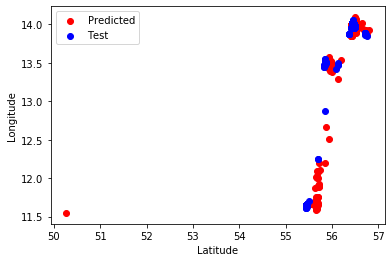

In [31]:
# create scatter plot
plt.scatter(y_lat_pred, y_long_pred, c='r', label='Predicted')
plt.scatter(y_lat_test, y_long_test, c='b', label='Test')

# add labels and legend
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

# show plot
plt.show()

In [32]:
X_test["population"].shape

(3983,)

In [33]:
y_lat_test_comb = pd.DataFrame(y_lat_test)
y_lat_test_comb.shape

(3983, 1)

In [34]:
y_long_test_comb = pd.DataFrame(y_long_test)
y_long_test_comb.shape

(3983, 1)

In [35]:
y_lat_pred_comb = pd.DataFrame(y_lat_pred)
y_lat_pred_comb.shape

(3983, 1)

In [36]:
y_long_pred_comb = pd.DataFrame(y_long_pred)
y_long_pred_comb.shape

(3983, 1)

In [37]:
pop_df = pd.DataFrame(X_test["population"].values.reshape(-1, 1))
pop_df.shape

(3983, 1)

In [38]:
# Create a dataframe with all the values, (predicted and actual), in order to be used for diagrams and comparisons.
combined_df = pd.concat([pop_df, y_lat_pred_comb, y_long_pred_comb, y_lat_test_comb, y_long_test_comb], axis=1)
combined_df.columns = ["population", "Pred_latitude", "Pred_longitude", "latitude", "longitude"]

In [39]:
combined_df = combined_df.dropna()

In [40]:
combined_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
0,71.0,56.480991,13.986930,56.439716,13.991791
3,88.0,56.453037,13.992968,56.441143,13.988527
6,131.0,56.486431,13.989398,56.439716,13.992242
17,27.0,56.446053,13.989341,56.439903,13.992476
19,23.0,56.459274,13.986702,56.439484,13.992446
31,67.0,56.455311,13.991185,56.439350,13.992638
34,24.0,56.438839,13.989224,56.440166,13.992716
35,131.0,56.486996,13.989350,56.439930,13.992993
41,152.0,56.485332,13.995910,56.440140,13.992735
42,152.0,56.494846,14.007483,56.440044,13.992678


In [41]:
#selecting the most frequent population of the populations that have more than 20 members.
threshold = 20
populations_above_threshold = combined_df['population'].value_counts()[combined_df['population'].value_counts() >= threshold].index
if len(populations_above_threshold) > 0:
    most_frequent_pop = combined_df.loc[combined_df['population'].isin(populations_above_threshold)]['population'].value_counts().idxmax()
    most_frequent_pop_df = combined_df.loc[combined_df['population'] == most_frequent_pop]
else:
    print("change the threshold!")


In [42]:
most_frequent_pop_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
41,152.0,56.485332,13.995910,56.440140,13.992735
42,152.0,56.494846,14.007483,56.440044,13.992678
181,152.0,56.480881,14.000496,56.440220,13.992155
218,152.0,56.487812,13.989176,56.440342,13.992517
257,152.0,56.127750,13.283204,56.439884,13.991575
449,152.0,56.450268,13.976133,56.439644,13.992051
466,152.0,56.504070,13.995362,56.439968,13.992618
836,152.0,56.515736,14.000311,56.439949,13.992587
1010,152.0,56.493633,13.973193,56.439953,13.993013
1063,152.0,56.503746,13.985280,56.439720,13.992579


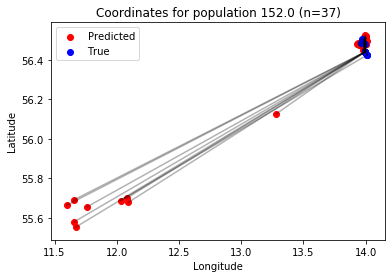

In [43]:
# Filter for rows with non-null predicted and true coordinates
filtered_df = most_frequent_pop_df.dropna(subset=['Pred_latitude', 'Pred_longitude', 'latitude', 'longitude'])

# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()


In [44]:
most_frequent_pop_df.shape

(37, 5)

In [45]:
# Removing outliers
filtered_df = filtered_df[(filtered_df['Pred_longitude'] >= 13.7) & (filtered_df['longitude'] >= 13.7)]

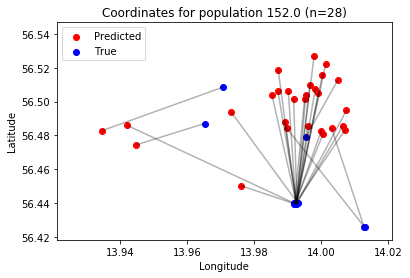

In [46]:
# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()

In [47]:
# Removing outliers
combined_df = combined_df[(combined_df['Pred_longitude'] >= 13.7) & (combined_df['longitude'] >= 13.7)]

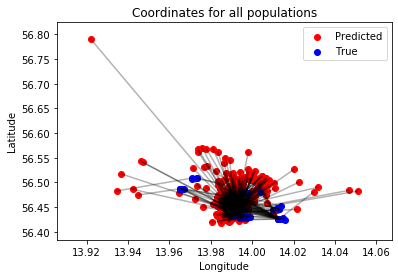

In [48]:
# Create scatter plot of predicted and true coordinates
plt.scatter(combined_df['Pred_longitude'], combined_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(combined_df['longitude'], combined_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in combined_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for all populations")

# Show plot
plt.show()